In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot, inverse_transform_new

In [2]:
df = pd.read_excel('all_data.xlsx')

In [3]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [4]:
df = df.drop(columns=['Date'])

In [5]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [6]:
X = df.drop('Close', axis=1)
y = df['Close']

In [7]:
X, y, scaler = scale_data(df)

In [8]:
X

array([[[0.07002981, 0.08061168, 0.08466681, ..., 0.24813463,
         1.        , 0.2962963 ]],

       [[0.08175457, 0.07736212, 0.0884934 , ..., 0.19324368,
         0.        , 0.32098765]],

       [[0.07772759, 0.07139575, 0.06324821, ..., 0.26609894,
         0.        , 0.40740741]],

       ...,

       [[0.74549014, 0.79388071, 0.76590194, ..., 0.3689383 ,
         1.        , 0.24691358]],

       [[0.81140218, 0.85358472, 0.85283922, ..., 0.57023243,
         1.        , 0.5308642 ]],

       [[0.87171075, 1.        , 0.9079946 , ..., 1.        ,
         1.        , 1.        ]]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        elif n_lstm == 3:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Training the model
        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history  # Return the training history if successful
    except Exception as e:
        print(f"Error during model training: {e}")
        return None  # Return None if there was an error

# Loop to try different configurations
def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {}  # Dictionary to store results
    
    # Loop through all combinations of parameters
    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                # Store history of the model in a dictionary
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                # Only store history if it is not None
                if history is not None:
                    # Storing the MSE for train and test
                    mse_train = history.history['loss'][-1]  # Last epoch's training MSE
                    mse_test = history.history['val_loss'][-1]  # Last epoch's validation (test) MSE
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

# Example usage
lstm_configs = {
    'n_lstm': [1, 2, 3],  # Number of LSTM layers
    'neurons': [50, 100, 150, 200],  # Number of neurons in each LSTM layer
    'epochs': [10, 20, 30]  # Number of epochs for training
}

In [11]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 292 samples, validate on 73 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
292/292 [==============================] - 1s 2ms/sample - loss: 0.0318 - val_loss: 0.0854
Epoch 2/10
292/292 [==============================] - 0s 75us/sample - loss: 0.0184 - val_loss: 0.0905
Epoch 3/10
292/292 [==============================] - 0s 62us/sample - loss: 0.0139 - val_loss: 0.1480
Epoch 4/10
292/292 [==============================] - 0s 63us/sample - loss: 0.0140 - val_loss: 0.1184
Epoch 5/10
292/292 [==============================] - 0s 87us/sample - loss: 0.0133 - val_loss: 0.1048
Epoch 6/10
292/292 [==============================] - 0s 80us/sample - loss: 0.0130 - val_loss: 0.1301
Epoch 7/10
292/292 [==============================] - 0s 84us/sample - loss: 

In [12]:
# Mengambil dan menyimpan nilai mse_train dan mse_test
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

# Menampilkan hasil
for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.01272004895065337, MSE Test: 0.1285387687895396
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012399558000241036, MSE Test: 0.15387050235924654
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.012361557643114245, MSE Test: 0.1457141102993325
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012624659358638607, MSE Test: 0.13047947581500224
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012655416784221179, MSE Test: 0.1391389620018332
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.012386148706180593, MSE Test: 0.15405384236819122
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.01250753669093733, MSE Test: 0.12671256820632987
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.012936010599544603, MSE Test: 0.136214674539762
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.012568750807836856, MSE Test: 0.14003289123512294
Experiment: n_lstm=1_neurons=200_epochs=10, MSE

In [13]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012720,0.128539
1,n_lstm=1_neurons=50_epochs=20,0.012400,0.153871
2,n_lstm=1_neurons=50_epochs=30,0.012362,0.145714
3,n_lstm=1_neurons=100_epochs=10,0.012625,0.130479
4,n_lstm=1_neurons=100_epochs=20,0.012655,0.139139
5,n_lstm=1_neurons=100_epochs=30,0.012386,0.154054
6,n_lstm=1_neurons=150_epochs=10,0.012508,0.126713
7,n_lstm=1_neurons=150_epochs=20,0.012936,0.136215
8,n_lstm=1_neurons=150_epochs=30,0.012569,0.140033
9,n_lstm=1_neurons=200_epochs=10,0.012667,0.132042


In [14]:
hp_lstm.to_excel("kombinasi-parameter.xlsx")

In [15]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=150_epochs=30
mse_train                           0.000283
mse_test                            0.000999
Name: 20, dtype: object


In [16]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=200_epochs=20
mse_train                           0.000284
mse_test                            0.000931
Name: 22, dtype: object


In [17]:
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Train on 292 samples, validate on 73 samples
Epoch 1/20
292/292 [==============================] - 6s 20ms/sample - loss: 0.0292 - val_loss: 0.0627
Epoch 2/20
292/292 [==============================] - 0s 451us/sample - loss: 0.0117 - val_loss: 0.0786
Epoch 3/20
292/292 [==============================] - 0s 399us/sample - loss: 0.0068 - val_loss: 0.0836
Epoch 4/20
292/292 [==============================] - 0s 418us/sample - loss: 0.0044 - val_loss: 0.0238
Epoch 5/20
292/292 [==============================] - 0s 514us/sample - loss: 0.0030 - val_loss: 0.0195
Epoch 6/20
292/292 [==============================] - 0s 411us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 7/20
292/292 [==============================] - 0s 419us/sample - loss: 6.3992e-04 - val_loss: 9.4301e-04
Epoch 8/20
292/292 [==============================] - 0s 411us/sample - loss: 4.5420e-04 - val_loss: 0.0022
Epoch 9/20
292/292 [==============================] - 0s 411us/sample - loss: 4.0651e-04 - val_loss: 9.8906e-04


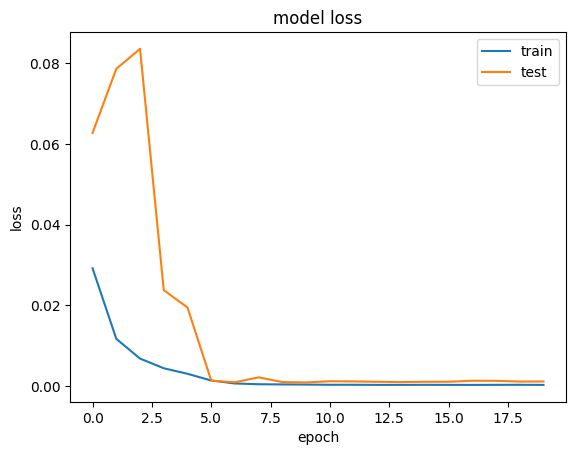

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [19]:
predictions_train = model.predict(X_train)
# Inverse transform predictions
inverse_predictions_train = inverse_transform(scaler, predictions_train)
# Inverse transform y_test
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,24045.441828,23475.466797
1,23804.737563,22362.679688
2,23223.367511,22353.349609
3,22600.035319,22435.513672
4,22727.158153,22429.757813


In [20]:
predictions_test = model.predict(X_test)
# Inverse transform predictions
inverse_predictions_test = inverse_transform(scaler, predictions_test)
# Inverse transform y_test
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

,Predicted,Actual
0,42103.535549,42270.527344
1,43348.480656,43652.250000
2,44141.710641,43869.152344
3,44086.776985,43997.902344
4,44835.359344,43739.542969


# METRIKS EVALUASI

In [21]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

# Menghitung R-squared
r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 707.465948248589
Root Mean Squared Error (RMSE) Test Set: 1428.2702947870935

R-squared Train Set: 0.9772702107996393
R-squared Test Set: 0.9134076824443566


# VISUALISASI

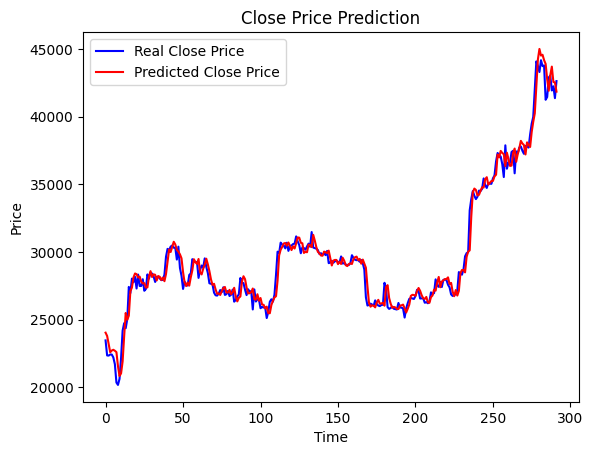

In [22]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


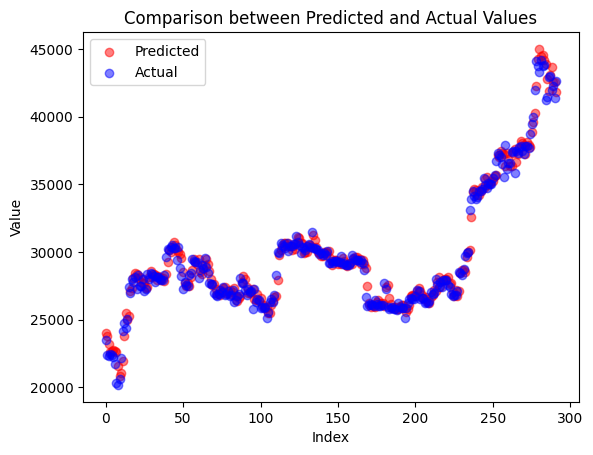

In [23]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


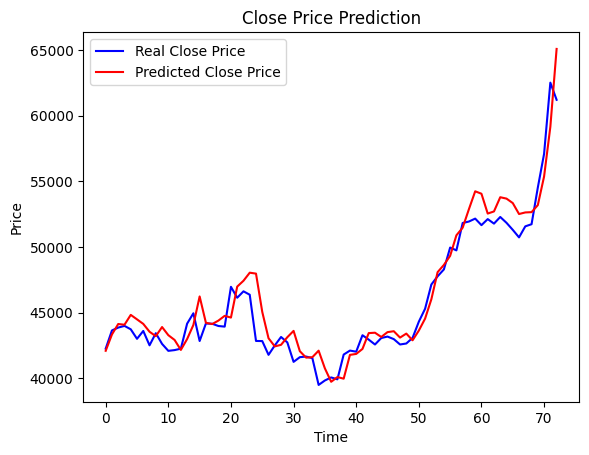

In [24]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

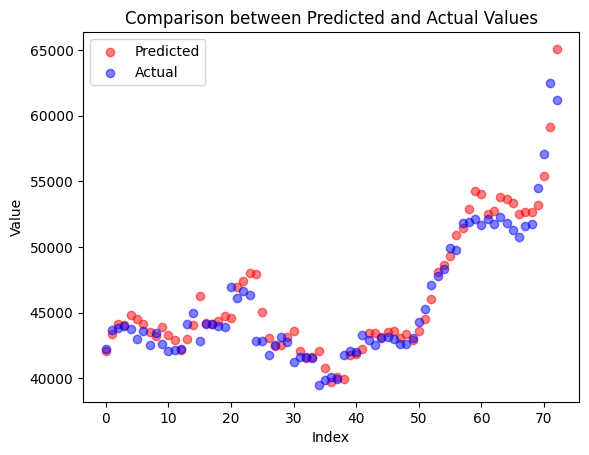

In [25]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [26]:
features = ["Open", "High", "Low", "Adj_Close", "Volume", "Sentimen", "Index"]

# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, X_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

# TEST DENGAN DATA BARU

In [48]:
dt = pd.read_excel('all_data_validation.xlsx')
dt

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2024-03-01,61168.062500,63155.101563,60802.527344,62440.632813,40186368423,positif,59,62440.632813
1,2024-03-02,62431.652344,62458.699219,61657.289063,62029.847656,23888473685,positif,46,62029.847656
2,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,26253811450,positif,44,63167.371094
3,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,70670471105,positif,81,68330.414063
4,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,102802940877,positif,100,63801.199219
5,2024-03-06,63776.050781,67637.929688,62848.671875,66106.804688,68750229073,positif,78,66106.804688
6,2024-03-07,66099.742188,68029.921875,65655.531250,66925.484375,46989543159,positif,62,66925.484375
7,2024-03-08,66938.093750,70083.054688,66230.453125,68300.093750,59202881172,positif,63,68300.093750
8,2024-03-09,68299.257813,68673.054688,68053.125000,68498.882813,21609650379,positif,52,68498.882813
9,2024-03-10,68500.257813,70005.203125,68239.976563,69019.789063,35683977532,negatif,56,69019.789063


In [49]:
dt = dt.drop(columns=["Date"])

In [50]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
dt['Sentimen'] = dt['Sentimen'].map(sentimen_mapping)

In [51]:
dt.describe()

,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
count,31.000000,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000,31.000000
mean,67372.752394,69272.725933,65532.276714,67702.439264,4.665864e+10,0.548387,56.419355,67702.439264
std,3292.243235,2911.385403,3273.325051,3157.882425,2.025387e+10,0.809885,15.751771,3157.882425
min,61168.062500,62458.699219,59323.910156,61912.773438,1.713024e+10,-1.000000,35.000000,61912.773438
25%,64693.548828,68068.425782,62617.595703,65403.253907,3.079077e+10,0.500000,45.500000,65403.253907
50%,68299.257813,69170.625000,65655.531250,68330.414063,4.448035e+10,1.000000,52.000000,68330.414063
75%,69770.613282,71456.761719,68472.476563,69925.820312,6.107452e+10,1.000000,63.000000,69925.820312
max,73079.375000,73750.070313,71334.093750,73083.500000,1.028029e+11,1.000000,100.000000,73083.500000


In [52]:
X_ = dt.drop(columns=['Close'])
y_ = dt['Close']

In [53]:
X, y, scalers = scale_data(dt)

In [54]:
# Lakukan prediksi dengan model
predictions = model.predict(X)  # Misalnya, model LSTM yang sudah dilatih

# Invers transformasi hasil prediksi
inverse_predictions_new = inverse_transform_new(scaler, predictions)

# Invers transformasi y_test
y_test_original_new = inverse_transform_new(scaler, y)

# Perbandingan antara hasil prediksi dan yang sebenarnya
compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new.flatten(), 'Actual': y_test_original_new.flatten()})
print(compare_model_test)

       Predicted        Actual
0   62711.944173  62029.847656
1   62822.637943  63167.371094
2   63201.724073  68330.414063
3   66603.490693  63801.199219
4   65898.711948  66106.804688
5   65933.502750  66925.484375
6   67367.080289  68300.093750
7   68731.884537  68498.882813
8   68968.697296  69019.789063
9   69477.994505  72123.906250
10  71519.842134  71481.289063
11  72424.440279  73083.500000
12  73622.547034  71396.593750
13  72544.422338  69403.773438
14  70475.963594  65315.117188
15  67752.560607  68390.625000
16  67587.581946  67548.593750
17  68537.411064  61912.773438
18  65321.724417  67913.671875
19  65690.082655  65491.390625
20  67095.568279  63778.761719
21  65137.891527  64062.203125
22  64710.079581  67234.171875
23  66396.871200  69958.812500
24  69571.928739  69987.835938
25  70903.934007  69455.343750
26  70675.179089  70744.953125
27  71015.616531  69892.828125
28  70847.145606  69645.304688
29  70286.357983  71333.648438


In [55]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 2407.8468006994854
R-squared Test Set: 0.3571347586184517


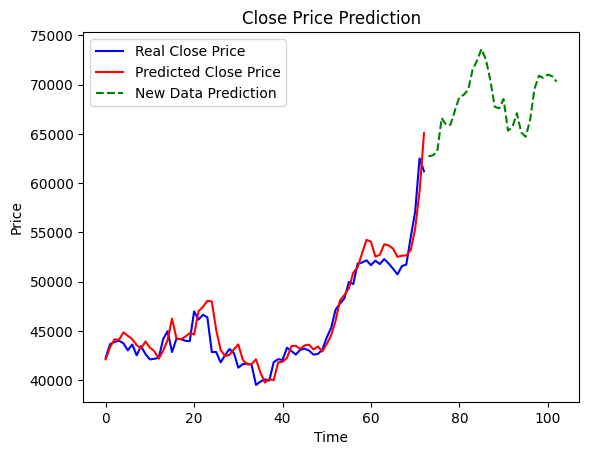

In [56]:
lineplot(y_test_original, inverse_predictions_test, inverse_predictions_new)

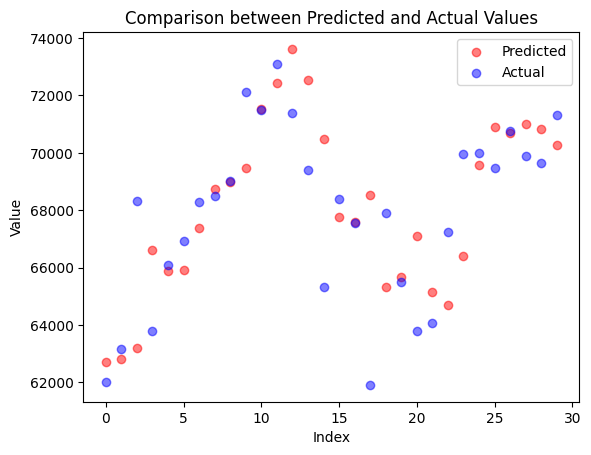

In [57]:
scatterplot(y_test_original_new, inverse_predictions_new)